## Workshop 3 - @scastellano

In [1]:
# Config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;} </style>""")

In [2]:
# Libraries and custom parameters
from datetime import date, timedelta
import numpy as np
import pandas as pd
import pickle
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets
import quantstats as qs

plt.style.use('seaborn-darkgrid')

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linewidth'] = 0.3
#plt.rcParams['legend.facecolor'] = '#2f3540'
plt.rcParams['ytick.labelright'] = plt.rcParams['ytick.right'] = True
plt.rcParams['lines.linewidth'] = 0.9

# Obtain data
Find a list of components (ticker + name) of Nikkei225 and download 5 years of data

    Download the list from the official website: https://indexes.nikkei.co.jp/en/nkave/index/component
    And historical data from Yahoo Finance using yfinance

In [3]:
# get_nikkei_data(bm="^N225", start_date="2015-01-01", from_local_file=True, save_to_file=Falsex)
# Returns a dataframe with historical data of each component of nikkei index from a starting date and company names.
#     Examples of codes and stock names in the website:
#     <div class="col-xs-3 col-sm-1_5">4151</div>
#     <a href="http://asia.nikkei.com/Company/07F754-E">KYOWA KIRIN CO., LTD.</a>

#     <div class="col-xs-3 col-sm-1_5">4502</div>
#     <a href="http://asia.nikkei.com/Company/05HWBL-E">TAKEDA PHARMACEUTICAL CO., LTD.</a>
        
def get_nikkei_data(bm="^N225", start_date="2015-01-01", from_local_file=True, save_to_file=False):
    if from_local_file == True:
        benchmark = pd.read_pickle('N225_hist_data.pkl')
        data = pd.read_pickle('N225_components_hist_data.pkl')
        dict_codes_names = pickle.load(open("N225_components.pkl", "rb"))
        return benchmark, data, dict_codes_names

    web = requests.get("https://indexes.nikkei.co.jp/en/nkave/index/component.html")
    try:
        web.raise_for_status()
    except Exception as exc:
        print("There was a problem: %s" % (exc))
    
    # Scrap website to get the stock_codes and stock_names
    soup = BeautifulSoup(web.text)
    soup_codes = soup.select('div[class="col-xs-3 col-sm-1_5"]')
    stock_codes = [s.getText()+".T" for s in soup_codes if s.getText() != "Code"]

    soup_names = soup.select('a[href^="http://asia.nikkei.com/Company/"]')
    stock_names = [s.getText() for s in soup_names if s.getText() != "Company Name"]

    if len(stock_codes) != len(stock_names):
        print("There was a problem with scrapping stocks.\nNumber of Company codes is {}\nNumber of Company names is: {}"
              .format(len(stock_codes), len(stock_names)))
        return

    # Download data from yfinance
    benchmark = yf.download(bm, auto_adjust=True, start=start_date)
    benchmark.columns = pd.MultiIndex.from_product([['N225'], benchmark.columns])
    benchmark.sort_index(axis=1)
    data = yf.download(stock_codes, auto_adjust=True, start=start_date)
    data = data.swaplevel(axis=1).sort_index(axis=1)

    # Create dictionary with {stock_code: stock_name} and save it in a pickle file
    dict_codes_names = dict(zip(stock_codes, stock_names))
    if save_to_file == True:
        f = open("N225_hist_data.pkl", "wb")
        pickle.dump(benchmark, f)
        f.close()
        f = open("N225_components_hist_data.pkl", "wb")
        pickle.dump(data, f)
        f.close()
        f = open("N225_components.pkl", "wb")
        pickle.dump(dict_codes_names, f)
        f.close()

    return benchmark, data, dict_codes_names

#benchmark, data, dict_codes_names = get_nikkei_data(start_date="2015-01-01", from_local_file=False, save_to_file=True)
benchmark, data, dict_codes_names = get_nikkei_data(start_date="2015-01-01", from_local_file=True, save_to_file=False)

n = 3
print("Printing first {} stocks from N225:".format(n))
print("\n".join("\t- {}: {}".format(k, v) for (k, v) in sorted(dict_codes_names.items())[:n]))
data.head(3)
benchmark.head(3)

Printing first 3 stocks from N225:
	- 1332.T: NIPPON SUISAN KAISHA, LTD.
	- 1333.T: MARUHA NICHIRO CORP.
	- 1605.T: INPEX CORP.


1332.T                                               1333.T  \
                 Close        High         Low        Open   Volume   Close   
Date                                                                          
2015-01-05  347.686798  350.483207  341.161845  349.551070  1831000  1820.0   
2015-01-06  338.365509  346.754737  337.433373  342.094055  1782900  1766.0   
2015-01-07  343.026123  344.890395  335.569033  335.569033  1750900  1767.0   

                                            ...        9983.T                \
              High     Low    Open  Volume  ...         Close          High   
Date                                        ...                               
2015-01-05  1830.0  1793.0  1800.0  182100  ...  41731.082031  42067.279333   
2015-01-06  1793.0  1766.0  1792.0  251200  ...  40963.988281  41428.035311   
2015-01-07  1783.0  1760.0  1760.0  188700  ...  41124.980469  41205.478416   

                                                     9984.T               \
                     Low          Open  Volume        Close         High   
Date                                                                       
2015-01-05  41001.865348  41271.770224  545000  3398.238281  3438.100314   
2015-01-06  40826.668242  41068.162104  844600  3326.107178  3353.156416   
2015-01-07  40727.225908  40727.225908  727000  3353.155762  3388.746857   

                                                
                    Low         Open    Volume  
Date                                            
2015-01-05  3372.612689  3409.152885  12466800  
2015-01-06  3319.463505  3339.394523  17874200  
2015-01-07  3321.835598  3321.835598  14975000  

[3 rows x 1125 columns]

N225                                                  
                    Open          High           Low         Close  Volume
Date                                                                      
2015-01-05  17325.679688  17540.919922  17219.220703  17408.710938  116500
2015-01-06  17101.580078  17111.359375  16881.730469  16883.189453  166000
2015-01-07  16808.259766  16974.609375  16808.259766  16885.330078  138600

    We will only care about 'Close' data from now on, and we want the index and its components in the same dataframe

In [4]:
b = benchmark.xs('Close', axis=1, level=1)
d = data.xs('Close', axis=1, level=1)
df = pd.concat([b, d], axis=1)
df.head(3)
del(b, d, data, benchmark)

,N225,1332.T,1333.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,1812.T,...,9502.T,9503.T,9531.T,9532.T,9602.T,9613.T,9735.T,9766.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,17408.710938,347.686798,1820.0,1174.262207,1460.625122,3148.027344,683.003296,760.345886,829.145325,888.690063,...,1249.049805,1031.118408,3015.794922,2076.964355,2595.147949,739.048401,6848.0,2104.007324,41731.082031,3398.238281
2015-01-06,16883.189453,338.365509,1766.0,1106.104980,1415.230591,3070.014893,666.366028,739.096924,808.566711,865.397888,...,1213.057739,994.946472,2930.941650,2007.095215,2509.499756,713.760864,6612.0,2034.946289,40963.988281,3326.107178
2015-01-07,16885.330078,343.026123,1767.0,1094.522827,1404.549805,3111.315674,666.366028,734.477539,805.994385,843.897339,...,1202.393433,989.141235,2907.501709,1994.053101,2495.225098,701.525024,6559.0,1980.075439,41124.980469,3353.155762


# Data Cleaning
Check possible errors in data. Handle missing and extra data (something very likely if the source is Yahoo)

    First thing that I see is that some components have data in Non-Business days from Japan, which causes many NaN values in such days.
    Solution: Filter data to only have Japanese business days. For this, I use the library holidays and enter some extra dates manually

In [5]:
# data_without_holidays(df, start=2015, end=2020)
# Returns a dataframe after removing rows from non-Business days in Japan.

def data_without_holidays(df, start=2015, end=2020):
    # jap_holidays is a dictionary: {date: name_of_holiday}
    jap_holidays = holidays.CountryHoliday('JP', years=list(range(start, end+1)))
    
    # We need to include some dates from 2018, 2019 and 2020 
    jap_holidays.append(['2018-01-02', '2018-01-03', '2018-12-31', '2019-01-02', '2019-01-03', '2019-12-31', '2020-01-02', '2020-01-03'])
    
    # Remove rows from df containing holidays
    series_holidays = pd.Series(list(jap_holidays.keys()))
    df = df[~df.index.isin(series_holidays)]
    return df       

print("Number of days before cleaning data: {}".format(len(df)))
df_clean = data_without_holidays(df)
print("Number of days after cleaning data: {}".format(len(df_clean)))
df_clean.head(3)

Number of days before cleaning data: 1418
Number of days after cleaning data: 1396


,N225,1332.T,1333.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,1812.T,...,9502.T,9503.T,9531.T,9532.T,9602.T,9613.T,9735.T,9766.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,17408.710938,347.686798,1820.0,1174.262207,1460.625122,3148.027344,683.003296,760.345886,829.145325,888.690063,...,1249.049805,1031.118408,3015.794922,2076.964355,2595.147949,739.048401,6848.0,2104.007324,41731.082031,3398.238281
2015-01-06,16883.189453,338.365509,1766.0,1106.104980,1415.230591,3070.014893,666.366028,739.096924,808.566711,865.397888,...,1213.057739,994.946472,2930.941650,2007.095215,2509.499756,713.760864,6612.0,2034.946289,40963.988281,3326.107178
2015-01-07,16885.330078,343.026123,1767.0,1094.522827,1404.549805,3111.315674,666.366028,734.477539,805.994385,843.897339,...,1202.393433,989.141235,2907.501709,1994.053101,2495.225098,701.525024,6559.0,1980.075439,41124.980469,3353.155762


<AxesSubplot:title={'center':'Number of stocks with missing values each day'}, xlabel='Date'>

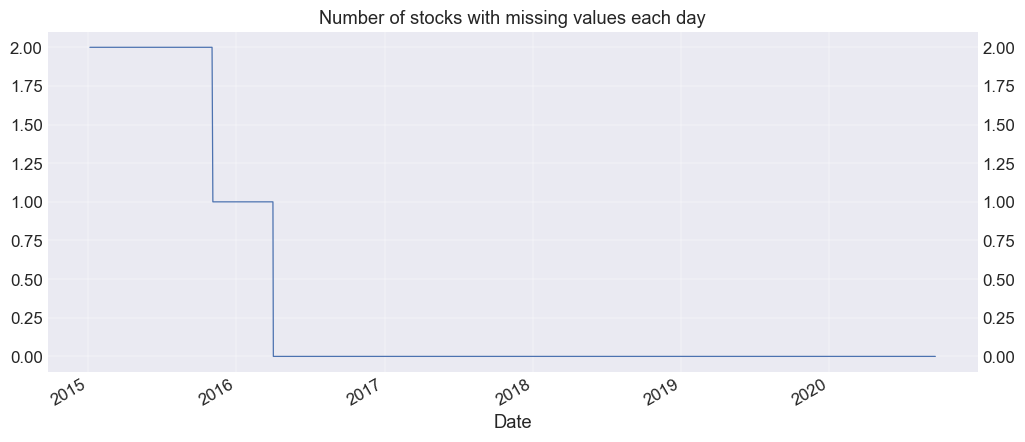

In [6]:
# Number of Nan each day (Row)
df_clean.isna().sum(axis=1).plot(title='Number of stocks with missing values each day')

Number of missing values of each stock:
6178.T    205.0
7186.T    305.0
dtype: float64


<AxesSubplot:title={'center':'Number of missing values of each stock'}>

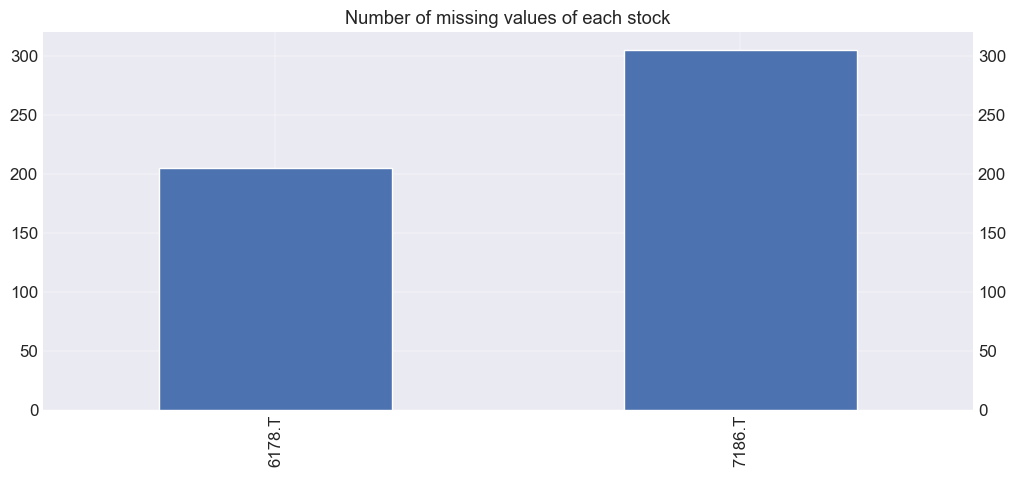

In [7]:
# We can see that three components have missing values #to check: df.loc[df['N225'].isna()]
print("Number of missing values of each stock:\n{}".format(df_clean.isna().sum(axis=0).replace(0, np.nan).dropna()))
df_clean.isna().sum(axis=0).replace(0, np.nan).dropna().plot.bar(title='Number of missing values of each stock')

# Correlations
Choose the 10 assets that have the least correlation with all other components. Calculate the equity for a weighted portfolio of those 10 assets and compare it with the evolution of the Nikkei225 in the 5 years of history.

    It is understood that the ideal portfolio will have a correlation of 0 among assets. Therefore, even if the exercise tells to take the 10 least correlated we will get the assets with correlations as close as possible to 0. 
    - Correlation of -1: strong (negative) correlation
    - Correlation of 0: weak correlation -> This is what we ideally want
    - Correlation of +1: strong (positive) correlation
    
    The problem is that by building a portfolio with the 10 least correlated companies during the period 2015-2020 we are looking at the future. 
    It would make more sense to create a strategy by building a portfolio for the period (n+1) with the 10 least correlated companies during period n

    First we obtain daily returns from each component

,N225,1332.T,1333.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,1812.T,...,9502.T,9503.T,9531.T,9532.T,9602.T,9613.T,9735.T,9766.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,96.981273,97.319056,97.032967,94.195740,96.892116,97.521862,97.564101,97.205356,97.518093,97.379044,...,97.118444,96.491971,97.186371,96.635997,96.699680,96.578365,96.553738,96.717643,98.161817,97.877397
2015-01-07,96.993569,98.659519,97.087912,93.209406,96.160869,98.833820,97.564101,96.597818,97.207855,94.959691,...,96.264651,95.928967,96.409132,96.008056,96.149628,94.922744,95.779790,94.109722,98.547602,98.673356


<AxesSubplot:title={'center':'N225 vs N225 components'}, xlabel='Date'>

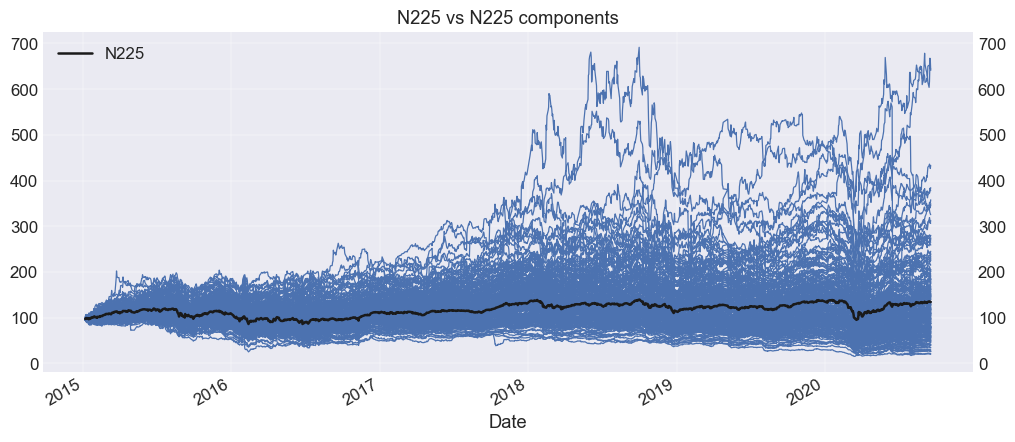

In [8]:
df_pct_change = df_clean.pct_change()

first_day = str(df_clean.index.min())
df_cum_ret = df_pct_change.add(1).cumprod().mul(100)
df_cum_ret.loc[first_day] = 100 + df_cum_ret.loc[first_day]*100

df_cum_ret.head(3)
ax = df_cum_ret.drop('N225', axis=1).plot(color='b', legend=False)
df_cum_ret['N225'].plot(title='N225 vs N225 components', legend=True, ax=ax, color='k', grid=True, linewidth=plt.rcParams['lines.linewidth']*2)

## Build a portfolio with the 10 least correlated companies and compare it with N225

In [9]:
# Returns a list with the n least correlated assets from df
def get_least_correlated(df, n=10):
    corr = df.drop(['N225', 'Portfolio_1', 'Portfolio_2'], axis=1, errors='ignore').corr().abs() # Remove the index
    corr['Tot_corr'] = corr.abs().sum(axis=0)
    least_correlated = sorted(list(corr['Tot_corr'].nsmallest(n).index))
    return least_correlated

# Functions for plotting
def plot_portfolio(df, portfolio_components, benchmark, title=''):
    ax = df[portfolio_components].plot()
    df[benchmark].plot(title=title, grid = True, ax=ax, color='k', linewidth=plt.rcParams['lines.linewidth']*2)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.yaxis.tick_left()
    plt.show()

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "10pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
    ]

def plot_heat_map(corr):
    cmap = sns.diverging_palette(5, 250, as_cmap=True)

    corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify())
    plt.show()

     Obtain the 10 least correlated actions

2269.T: MEIJI HOLDINGS CO., LTD.
4503.T: ASTELLAS PHARMA INC.
4689.T: Z HOLDINGS CORP.
5901.T: TOYO SEIKAN GROUP HOLDINGS, LTD.
6952.T: CASIO COMPUTER CO., LTD.
7911.T: TOPPAN PRINTING CO., LTD.
9005.T: TOKYU CORP.
9064.T: YAMATO HOLDINGS CO., LTD.
9501.T: TOKYO ELECTRIC POWER COMPANY HOLDINGS, I
9502.T: CHUBU ELECTRIC POWER CO., INC.


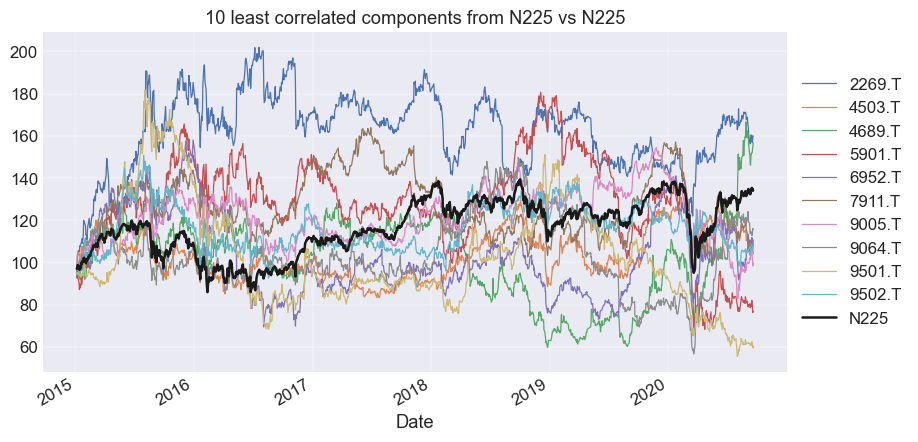

In [10]:
portfolio_stocks = get_least_correlated(df_cum_ret, n=10)

for st in portfolio_stocks:
    print("{}: {}".format(st, dict_codes_names.get(st)))

plot_portfolio(df_cum_ret, portfolio_stocks, 'N225', title='10 least correlated components from N225 vs N225')

### Construimos el portfolio con esas 10 acciones

['2269.T', '4503.T', '4689.T', '5901.T', '6952.T', '7911.T', '9005.T', '9064.T', '9501.T', '9502.T']
Sharpe ratio of portfolio_1: 0.31
Sharpe ratio of N225: 0.39


,N225,Portfolio_1,1332.T,1333.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,...,9502.T,9503.T,9531.T,9532.T,9602.T,9613.T,9735.T,9766.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,96.981273,97.061284,97.319056,97.032967,94.195740,96.892116,97.521862,97.564101,97.205356,97.518093,...,97.118444,96.491971,97.186371,96.635997,96.699680,96.578365,96.553738,96.717643,98.161817,97.877397
2015-01-07,96.993569,96.387311,98.659519,97.087912,93.209406,96.160869,98.833820,97.564101,96.597818,97.207855,...,96.264651,95.928967,96.409132,96.008056,96.149628,94.922744,95.779790,94.109722,98.547602,98.673356
2015-01-08,98.612124,98.184486,97.855218,97.032967,93.816378,96.343678,100.000000,98.974364,97.326865,98.241988,...,97.260750,95.928967,98.041351,96.770559,97.873125,96.026500,97.108645,94.919073,100.771588,99.734661
2015-01-09,98.788075,98.282623,98.123330,95.769231,93.740522,95.795232,101.166188,99.358973,96.597818,99.689754,...,97.936674,95.062793,98.476600,97.914313,97.506417,95.584986,97.283879,92.401074,101.577212,100.600473


<AxesSubplot:title={'center':'N225 non-correlated components vs N225'}, xlabel='Date'>

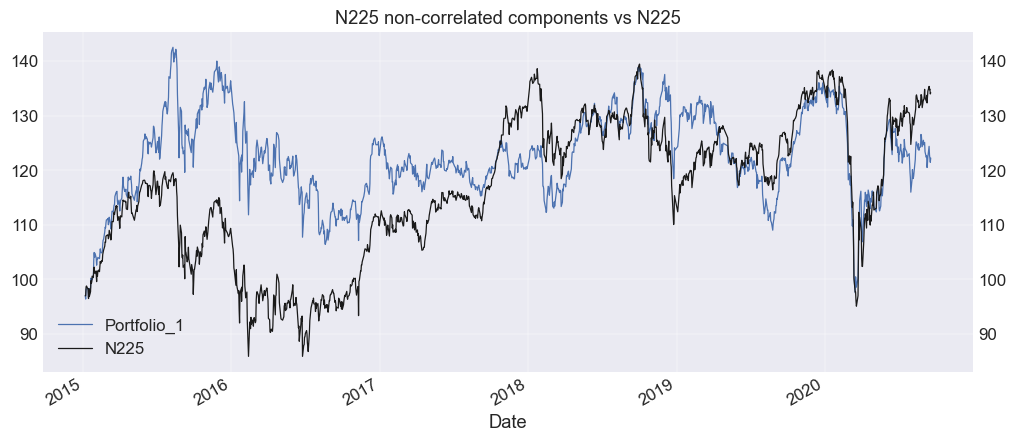

In [11]:
print(portfolio_stocks)

# Get portfolio returns
if 'Portfolio_1' not in df_cum_ret.columns:
    df_pct_change.insert(loc=1, column='Portfolio_1', value=df_pct_change[portfolio_stocks].mean(axis=1))
    df_cum_ret.insert(loc=1, column='Portfolio_1', value=df_pct_change['Portfolio_1'].add(1).cumprod().mul(100))
    df_cum_ret.loc[first_day] = 100 + df_cum_ret.loc[first_day]*100
    
print("Sharpe ratio of portfolio_1: {:.2f}\nSharpe ratio of N225: {:.2f}".format(qs.stats.sharpe(df_cum_ret['Portfolio_1']), qs.stats.sharpe(df_cum_ret['N225'])))

df_cum_ret.head()

ax = df_cum_ret['Portfolio_1'].plot(legend=True, color='b')
df_cum_ret['N225'].plot(title='N225 non-correlated components vs N225', legend=True, ax=ax, color='k')

# Rolling window correlation
Calculate the rolling correlation with a 130-day trading window of all assets in the portfolio and Nikkei to each other for each day.

In [12]:
def plot_correlation(corr, date):
    rdrd = sns.diverging_palette(h_neg=10, h_pos=10, as_cmap=True, s=100, l=25)
    fig, ax = plt.subplots(figsize=(3,3))
    fig = sns.heatmap(corr.round(2), cmap=rdrd, vmax=1.0, vmin=-1.0, annot=False, linecolor='black')
    cbar = fig.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    _ = ax.set(title=date.strftime('Rolling window correlation (130 Days) as of: %Y-%m-%d'))
    _ = ax.xaxis.tick_top()
    _ = ax.yaxis.tick_left()
    _ = plt.xticks(rotation=30)
    _ = plt.yticks(rotation=0)
    _ = plt.xticks(fontsize=6)
    _ = plt.yticks(fontsize=6)     

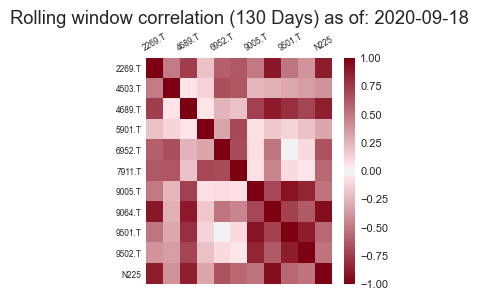

In [13]:
if 'N225' not in portfolio_stocks:
    portfolio_stocks.append('N225')

#df_rolling_corr = pd.read_pickle('Correlation_window_130D.pkl')
df_rolling_corr = df_cum_ret[portfolio_stocks].drop('Portfolio', errors='ignore').rolling(window=130).corr()
#df_rolling_corr.to_pickle('Correlation_window_130D.pkl')
portfolio_stocks.remove('N225')

date = pd.to_datetime('2020-09-18')
corr = df_rolling_corr.loc[date]
plot_correlation(corr, date)

In [14]:
options = [(date.strftime(' %Y-%m-%d '), date) for date in df_cum_ret.index]

selection_slider = widgets.SelectionSlider(
    options=options,
    description='Dates',
    orientation='horizontal',
    layout={'width': '1000px'},
)
#selection_range_slider

In [15]:
def print_date(date):
    #print(date.strftime('%Y-%m-%d'))
    if 'N225' not in portfolio_stocks:
        portfolio_stocks.append('N225')
    
    corr = df_rolling_corr.loc[date].copy()
    plot_correlation(corr.loc[portfolio_stocks, portfolio_stocks], date)
    portfolio_stocks.remove('N225')
    
widgets.interact(
    print_date,
    date=selection_slider
);

interactive(children=(SelectionSlider(description='Dates', layout=Layout(width='1000px'), options=((' 2015-01-…

# Investment strategy: portfolio built with 10 least correlated stocks from previous month

In [16]:
OOS_start_date = pd.date_range(start='2015-01-01', end='2020-09-01', freq='1MS', closed=None)
OOS_end_date = pd.date_range(start='2015-01-31', end='2020-09-30', freq='1M', closed=None)
# for oi, oe in zip(OOS_start_date, OOS_end_date):
#     print("{:%Y-%m-%d} {:%Y-%m-%d}".format(oi, oe))

Date  Date
2015  1                                                      []
      2       [1802.T, 1812.T, 4578.T, 6178.T, 6301.T, 6305....
      3       [1333.T, 2802.T, 3402.T, 5631.T, 6178.T, 6702....
dtype: object

Sharpe ratio of portfolio_2: 0.09
Sharpe ratio of N225: 0.39


,N225,Portfolio_1,1332.T,1333.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,...,9503.T,9531.T,9532.T,9602.T,9613.T,9735.T,9766.T,9983.T,9984.T,Portfolio_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,96.981273,97.061284,97.319056,97.032967,94.195740,96.892116,97.521862,97.564101,97.205356,97.518093,...,96.491971,97.186371,96.635997,96.699680,96.578365,96.553738,96.717643,98.161817,97.877397,NaN
2015-01-07,96.993569,96.387311,98.659519,97.087912,93.209406,96.160869,98.833820,97.564101,96.597818,97.207855,...,95.928967,96.409132,96.008056,96.149628,94.922744,95.779790,94.109722,98.547602,98.673356,NaN
2015-01-08,98.612124,98.184486,97.855218,97.032967,93.816378,96.343678,100.000000,98.974364,97.326865,98.241988,...,95.928967,98.041351,96.770559,97.873125,96.026500,97.108645,94.919073,100.771588,99.734661,NaN
2015-01-09,98.788075,98.282623,98.123330,95.769231,93.740522,95.795232,101.166188,99.358973,96.597818,99.689754,...,95.062793,98.476600,97.914313,97.506417,95.584986,97.283879,92.401074,101.577212,100.600473,NaN


<AxesSubplot:title={'center':'N225 non-correlated components vs N225'}, xlabel='Date'>

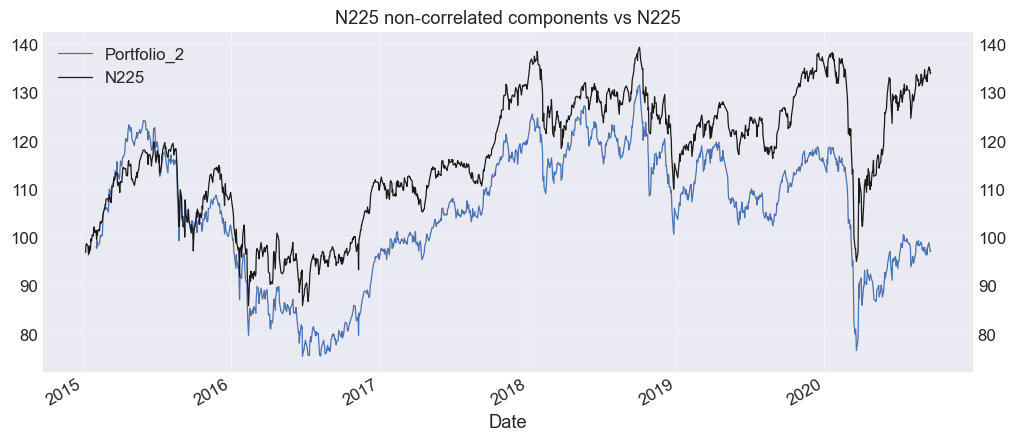

In [17]:
portfolio_stocks_walk_forward = df_cum_ret.groupby(by=[df_cum_ret.index.year, df_cum_ret.index.month]).apply(get_least_correlated, n=10).shift(1)
portfolio_stocks_walk_forward.iloc[0] = []
portfolio_stocks_walk_forward.head(3)

pct_change_portfolio_2 = pd.Series(dtype='float64')

# Build investing portfolio for each month
for start, end, portf_st_w_f in zip(OOS_start_date, OOS_end_date, portfolio_stocks_walk_forward):
    #print("Month {:%Y-%m-%d} - {:%Y-%m-%d}:".format(start, end))
    #print(portf_st_w_f)
    pct_change_portfolio_2 = pct_change_portfolio_2.append(df_pct_change.loc[start:end, portf_st_w_f].mean(axis=1))
    
df_pct_change['Portfolio_2'] = pct_change_portfolio_2
df_cum_ret['Portfolio_2'] = df_pct_change['Portfolio_2'].add(1).cumprod().mul(100)
df_cum_ret.loc[first_day, 'Portfolio_2'] = 100 + df_pct_change.loc[first_day, 'Portfolio_2']*100
    
print("Sharpe ratio of portfolio_2: {:.2f}\nSharpe ratio of N225: {:.2f}".format(qs.stats.sharpe(df_cum_ret['Portfolio_2']), qs.stats.sharpe(df_cum_ret['N225'])))

df_cum_ret.head()

ax = df_cum_ret['Portfolio_2'].plot(legend=True, color='b')
df_cum_ret['N225'].plot(title='N225 non-correlated components vs N225', legend=True, ax=ax, color='k')

# Conclusions of both portfolios

## Equity curve

Sharpe ratio of portfolio_1: 0.31
Sharpe ratio of portfolio_2: 0.09
Sharpe ratio of N225: 0.39


,N225,Portfolio_1,Portfolio_2
Date,,,
2020-09-18,134.187424,122.212208,97.215162


<AxesSubplot:title={'center':'Comparison of portfolios´ returns'}, xlabel='Date'>

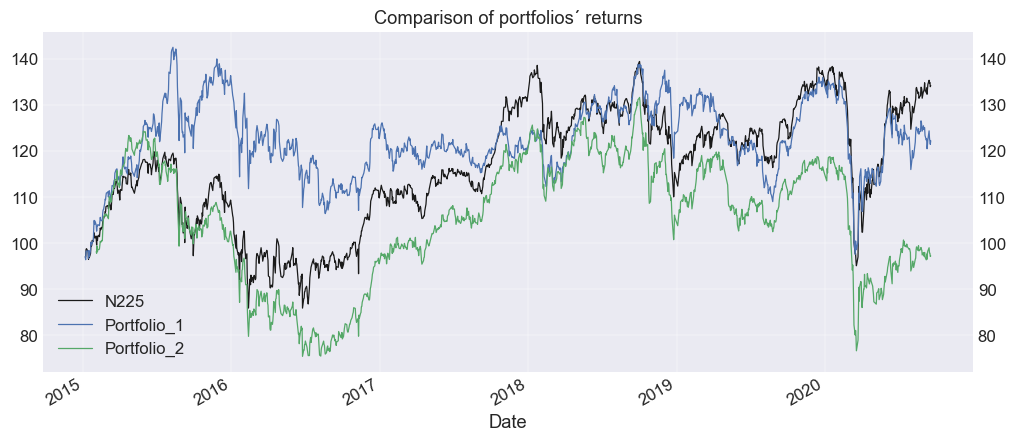

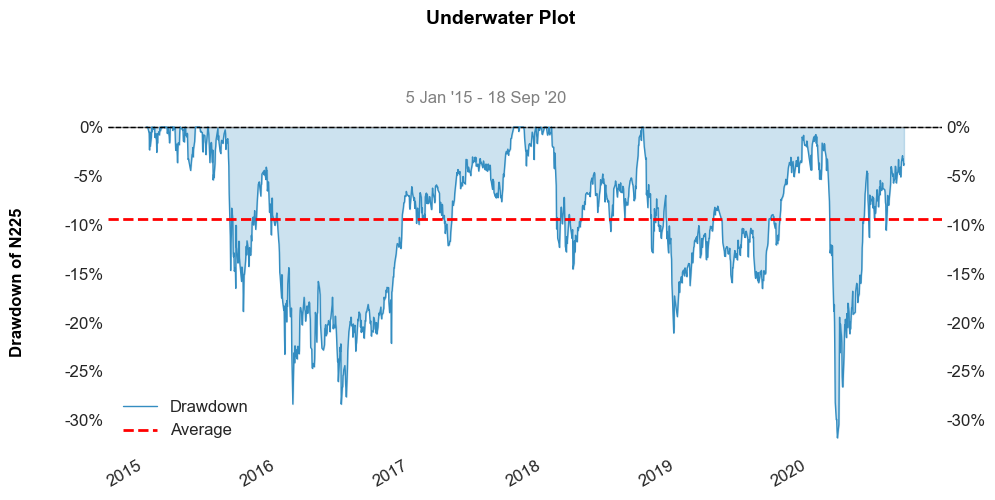

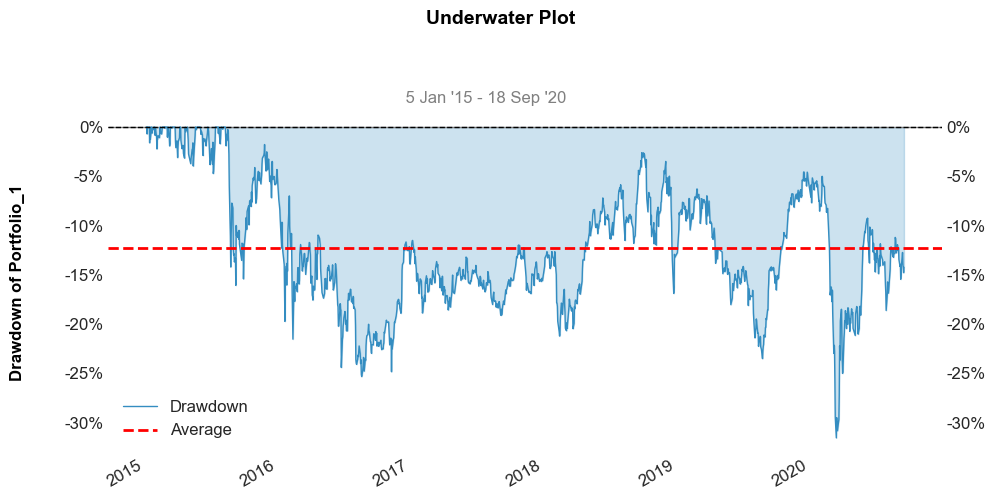

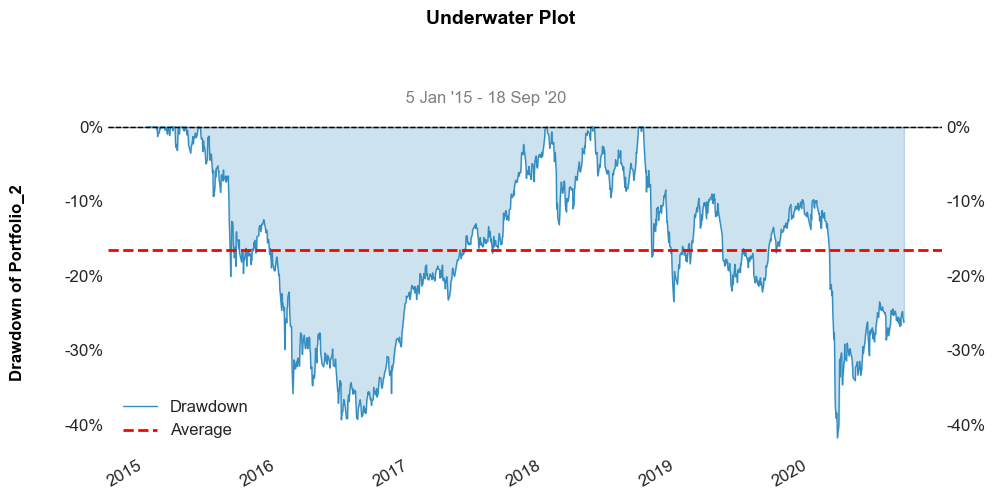

In [18]:
comparison = ['N225', 'Portfolio_1', 'Portfolio_2']
print("Sharpe ratio of portfolio_1: {:.2f}\nSharpe ratio of portfolio_2: {:.2f}\nSharpe ratio of N225: {:.2f}".format(qs.stats.sharpe(df_cum_ret['Portfolio_1']), qs.stats.sharpe(df_cum_ret['Portfolio_2']), qs.stats.sharpe(df_cum_ret['N225'])))

df_cum_ret[comparison].tail(1)

df_cum_ret[comparison].plot(title='Comparison of portfolios´ returns', color=['k', 'b', 'g'])
qs.plots.drawdown(df_cum_ret['N225'], ylabel="Drawdown of N225")
qs.plots.drawdown(df_cum_ret['Portfolio_1'], ylabel="Drawdown of Portfolio_1")
qs.plots.drawdown(df_cum_ret['Portfolio_2'], ylabel="Drawdown of Portfolio_2")

    - Since we used data from all 5 years to build the composition of portfolio_1 from day 1, we had a clear look-ahead bias. Therefore this is not a realistic way of testing a strategy, but it would allow to proof whether such portfolio would have lower drawdowns than N225. As we can see in the previous plots, this has not been accomplished, even with a look-ahead bias.
    - Portfolio_2 was build similarly to Portfolio_1, but avoiding this look-ahead bias to make it as a more realisting investment strategy. Portfolio_2 buys for each month the 10 least correlated stocks from the previous month. This strategy does not seem improve the benchmark in any metric. It delivered a lower final return, lower SR, larger DD...

## Rolling volatility

    As the goal of this work was to check whether investing in less correlated assets would lower the volatility and increase SR of its benchmark, rolling volatilities of both portfolios are plotted against the benchmark

Final return of portfolio_1: 22.21%
Final return of N225: 34.19%
STD of portfolio_1: 0.0127
STD of N225: 0.0132
Sharpe ratio of portfolio_1: 0.28
Sharpe ratio of N225: 0.36 (Calculated as returns.mean()/returns.std()


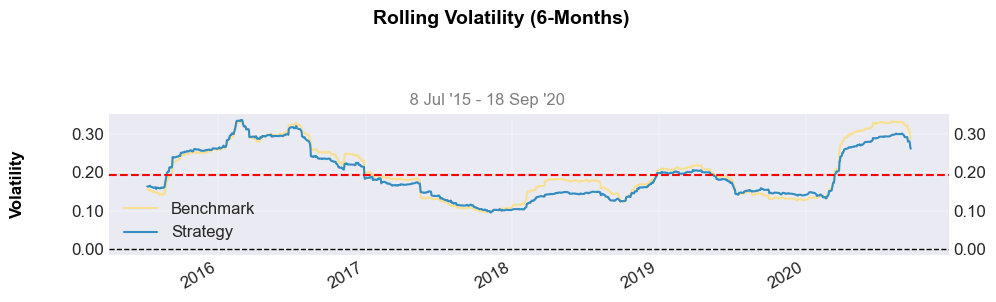

In [19]:
print("Final return of portfolio_1: {:.2f}%\nFinal return of N225: {:.2f}%".format(df_cum_ret['Portfolio_1'].iloc[-1]-100, df_cum_ret['N225'].iloc[-1]-100))
print("STD of portfolio_1: {:.4f}\nSTD of N225: {:.4f}".format(df_pct_change['Portfolio_1'].std(), df_pct_change['N225'].std()))
print("Sharpe ratio of portfolio_1: {:.2f}\nSharpe ratio of N225: {:.2f} (Calculated as returns.mean()/returns.std()".format(qs.stats.sharpe(df_pct_change['Portfolio_1']), qs.stats.sharpe(df_pct_change['N225'])))
qs.plots.rolling_volatility(df_cum_ret['Portfolio_1'], benchmark=df_cum_ret['N225'], period=126)

    - We can see how Portfolio_1 generally has a lower volatility than the benchmark. Though it was not enough to improve the benchmark's sharpe ratio over the last 5 years. Returns of the benchmark improved our portfolio's returns by around 12% and a SR of 0,36 vs 0,28 of Portfolio_1

Final return of portfolio_2: -2.78%
Final return of N225: 34.19%
STD of portfolio_2: 0.0130
STD of N225: 0.0132
Sharpe ratio of portfolio_2: 0.08 (Calculated as returns.mean()/returns.std())
Sharpe ratio of N225: 0.36


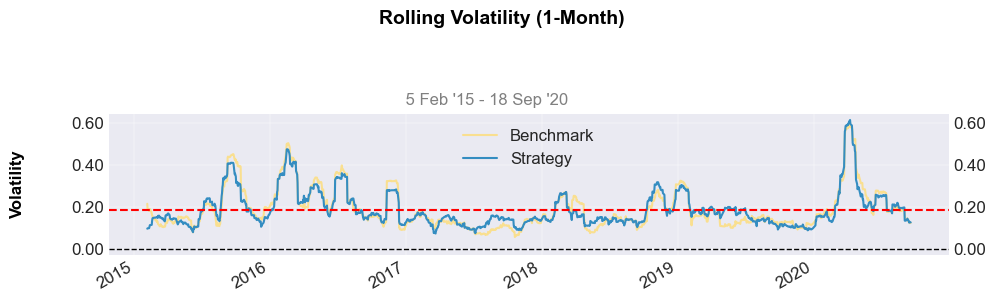

In [20]:
print("Final return of portfolio_2: {:.2f}%\nFinal return of N225: {:.2f}%".format(df_cum_ret.loc['2015-02':, 'Portfolio_2'].iloc[-1]-100, df_cum_ret['N225'].iloc[-1]-100))
print("STD of portfolio_2: {:.4f}\nSTD of N225: {:.4f}".format(df_pct_change.loc['2015-02':, 'Portfolio_2'].std(), df_pct_change['N225'].std()))
print("Sharpe ratio of portfolio_2: {:.2f} (Calculated as returns.mean()/returns.std())\nSharpe ratio of N225: {:.2f}".format(qs.stats.sharpe(df_pct_change.loc['2015-02':, 'Portfolio_2']), qs.stats.sharpe(df_pct_change['N225'])))
qs.plots.rolling_volatility(df_pct_change['Portfolio_2'], benchmark=df_pct_change['N225'], period=22, period_label='1-Month')

    - In the more realistic example of building a portfolio based on the least correlated stocks from N225, this strategy has failed in all metrics compared to the benchmark. It delivered a negative return of -2% over the 5-year period and the standard deviation of returns was larger than in the benchmark.